# Loading raw data in dictionary format from pickle file

In [1]:
import pickle
import numpy as np

data_dict = {}
filename = 'data_dict.pickle'
# Retrieve the dictionary from the file
with open(filename, 'rb') as file:
    data_dict = pickle.load(file)

# Print the retrieved dictionary
print(np.array(data_dict[0]).shape)# category 1
print(np.array(data_dict[1]).shape)# category 2
print(np.array(data_dict[2]).shape)# category 3

(48, 13, 5, 140, 140)
(32, 13, 5, 140, 140)
(32, 13, 5, 140, 140)


# Data Preprocessing

- Channel order: Blue:0, Green:1, Red:2, Red-edge:3, NIR:4
- data_dict : has all the data in vector form

### Fuction for analysis on combinations of Channels and Number of days

In [2]:
def custom_data_dict(data_dict, channel=[0,1,2,3,4],n_days=13):
    new_data_dict = {}
    for key in list(data_dict.keys()):
        data = data_dict[key]
        
        # Days separation
        category = []
        for i in range(len(data)):
            img_sequence = []
            for j in range(n_days):
                img_sequence.append(data[i][j])
            category.append(img_sequence)
        
        # Channel Separation
        category1 = []
        for i in range(len(category)):
            img_seq = []
            for j in range(len(category[i])):
                img = []
                for k in range(len(category[i][j])):
                    img = category[i][j][channel,:,:]
                img_seq.append(img)
            category1.append(img_seq)

        # storing data into new customized dictionary
        new_data_dict[key] = category1
    
    return new_data_dict

### Enter the different scenarios here to form the custom ```data_dict```

In [3]:
data_dict = custom_data_dict(data_dict)

# Print the retrieved dictionary
print(np.array(data_dict[0]).shape)# category 1
print(np.array(data_dict[1]).shape)# category 2
print(np.array(data_dict[2]).shape)# category 3

(48, 13, 5, 140, 140)
(32, 13, 5, 140, 140)
(32, 13, 5, 140, 140)


## Dataset Class

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

- **Applying Transforms on Image** 
    - Part of Data Augmentation process

In [5]:
transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=3),
    #transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    #transforms.Normalize(mean=[0.5] * 5, std=[0.5] * 5),
])

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.transform = transform
        self.data = self._get_data()
    
    def _get_data(self):
        data = []
        labels = []
        for key in self.keys:
            sequences = self.data_dict[key]
            transformed_sequences = []
            for sequence in sequences:
                transformed_sequence = []
                #for image in sequence:
                #transformed_image = self.transform(image.transpose(2, 1, 0))
                #transformed_image = self.transform(image)
                transformed_sequence = self.transform(torch.tensor(sequence))#append(transformed_image)
                #transformed_sequences.append(torch.stack(transformed_sequence))
                transformed_sequence = torch.stack([transforms.ToTensor()(img.transpose(2, 1, 0)) for img in transformed_sequence.numpy()])
                transformed_sequences.append(transformed_sequence)
            data.extend(transformed_sequences)
            labels.extend([key] * len(transformed_sequences))
        return data, labels
    
    def __len__(self):
        return len(self.data[0])
    
    def __getitem__(self, index):
        sequence = self.data[0][index]
        label = self.data[1][index]
        
        return sequence, torch.tensor(self.keys.index(label))

In [7]:
class FinalDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [8]:
dataset = TimeSeriesDataset(data_dict, transform=transform)

# Split the dataset into train and test sets using scikit-learn
data_train, data_test, labels_train, labels_test = train_test_split(
    dataset.data[0], dataset.data[1], test_size=0.2, stratify=dataset.data[1], random_state=42
)

train_dataset = FinalDataset(data_train, labels_train)
test_dataset = FinalDataset(data_test, labels_test)

```
# Pickling the above dataset class objects: 'train_dataset' and 'test_dataset'
#   to be used later and save time in above transformations.

# Iterate over the DataLoader to get the data batches
train_data_batches = list(train_dataset)

# Pickle the data_batches object
with open('train_dataset_batches.pkl', 'wb') as file:
    pickle.dump(train_data_batches, file)
```

## Dataloader Class

In [9]:
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Creation

In [28]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

- **Model variants created:**
    - model3 : Alexnet
    - model4 : Alexnet + Deform Convolution
    - model5 : AlexNet + Weighted Attention
    - model6 : AlexNet + DeformConvLayer + Weighted Attention



    - model7  : VGG-16 
    - model8  : VGG-16 + Deform Convolution 
    - model9  : VGG-16 + Weighted Attention
    - model10 : VGG-16 + DeformConvLayer + Weighted Attention 
- To be implemented: 
    - model  : ResNet 
    - model  : ResNet + Deform Convolution 
    - model  : ResNet + Weighted Attention
    - model  : ResNet + DeformConvLayer + Weighted Attention

- Backbone: 
    - Spectrum Net: 
    ''' 
    spectrum_net.py
    '''
    - model11 : Spectrum_Net + Weighted Attention
    - model12 : Spectrum_Net 


In [11]:
#from model_non_attention import ARCNN
from model3 import ARCNN


In [12]:
NUM_CLASSES = 3
LR = 1e-5
SEED = 42
n_days = 13

In [13]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [14]:
def initialize_weights(module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)

# Training and Testing

### Parameters for training 

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Create an instance of the ARCNN model
model = ARCNN(num_classes=NUM_CLASSES).apply(initialize_weights).to(device)

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Set the number of training epochs
num_epochs = 100

#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Device: cuda


In [17]:
print(model)

ARCNN(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(5, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Identity()
  )
  (base_model): AlexNet(
    (features): Sequen

### Training and Testing Loop

In [18]:
# Training loop
epoch_loss = []
epoch_acc = [0]
best_epoch = 0
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    
    # Iterate over the training dataset
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the model's parameters
        optimizer.step()

        #if epoch == 26:
            # Update the scheduler
            #scheduler.step()
        
        # Accumulate the loss
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    epoch_loss.append(average_loss)
    
    # Print the average loss for the epoch
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    
    if epoch % 1 == 0 or epoch == num_epochs-1:
        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss   : {average_loss:.4f}")
        print(f"LR Val       : {optimizer.param_groups[0]['lr']}")
        model.eval()

        # Lists to store true labels, predicted labels, and confidence scores
        true_labels = []
        predicted_labels = []
        #confidence_scores = []

        # Iterate over the testing dataset
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate confidence scores
                scores = torch.softmax(outputs, dim=1)
                confidences, predicted = torch.max(scores, dim=1)

                # Append true labels, predicted labels, and confidence scores
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
                #confidence_scores.extend(confidences.cpu().numpy())

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predicted_labels)
        if accuracy > max(epoch_acc):
            best_epoch = epoch
        epoch_acc.append(accuracy)
        #if accuracy > max(epoch_acc):
            #best_epoch = epoch

        # Generate classification report
        #classification_report = classification_report(true_labels, predicted_labels)

        # Print accuracy and classification report
        print(f"Test Accuracy: {accuracy:.4f}\n")
        #print("Classification Report:")
        #print(classification_report)
        

print("Training finished.")
print(f"Min. Train Loss: {min(epoch_loss):.4f}\nMax. Test Acc.: {max(epoch_acc)*100.0:.4f}\nMax. Test Acc. obtained at epoch: {best_epoch+1}")

Epoch [1/100]
Train Loss   : 1.1055
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [2/100]
Train Loss   : 1.0735
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [3/100]
Train Loss   : 1.0639
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [4/100]
Train Loss   : 1.0487
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [5/100]
Train Loss   : 1.0421
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [6/100]
Train Loss   : 1.0276
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [7/100]
Train Loss   : 1.0152
LR Val       : 1e-05
Test Accuracy: 0.4783

Epoch [8/100]
Train Loss   : 1.0057
LR Val       : 1e-05
Test Accuracy: 0.5652

Epoch [9/100]
Train Loss   : 0.9839
LR Val       : 1e-05
Test Accuracy: 0.4348

Epoch [10/100]
Train Loss   : 0.9700
LR Val       : 1e-05
Test Accuracy: 0.6957

Epoch [11/100]
Train Loss   : 0.9587
LR Val       : 1e-05
Test Accuracy: 0.5652

Epoch [12/100]
Train Loss   : 0.9471
LR Val       : 1e-05
Test Accuracy: 0.5652

Epoch [13/100]
Train Loss   : 0.9441


In [29]:
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate confidence scores
        scores = torch.softmax(outputs, dim=1)
        confidences, predicted = torch.max(scores, dim=1)

        # Append true labels, predicted labels, and confidence scores
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        #confidence_scores.extend(confidences.cpu().numpy())

# Calculate accuracy
#accuracy = accuracy_score(true_labels, predicted_labels)

# Generate classification report
classification_report = classification_report(true_labels, predicted_labels)

# Print accuracy and classification report
#print(f"Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n")
print(classification_report)

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        50
           1       1.00      1.00      1.00        35
           2       0.83      0.83      0.83        30

    accuracy                           0.91       115
   macro avg       0.91      0.91      0.91       115
weighted avg       0.91      0.91      0.91       115



In [20]:
for i in range(3):
    idx = np.where(np.array(true_labels) == i)
    true = np.array(true_labels)[idx]
    pred = np.array(predicted_labels)[idx]
    accuracy = accuracy_score(true, pred)
    print(f"Class: {i} Accuracy: {accuracy:4f}\n")

Class: 0 Accuracy: 0.900000

Class: 1 Accuracy: 1.000000

Class: 2 Accuracy: 0.833333



In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

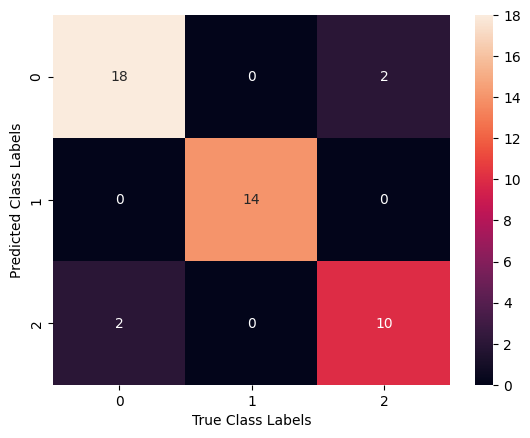

In [22]:
import seaborn as sns
#sns.heatmap(cm, annot=True)
ax = sns.heatmap(cm, annot=True)
ax.set(xlabel="True Class Labels", ylabel="Predicted Class Labels")
print()

### Plots 

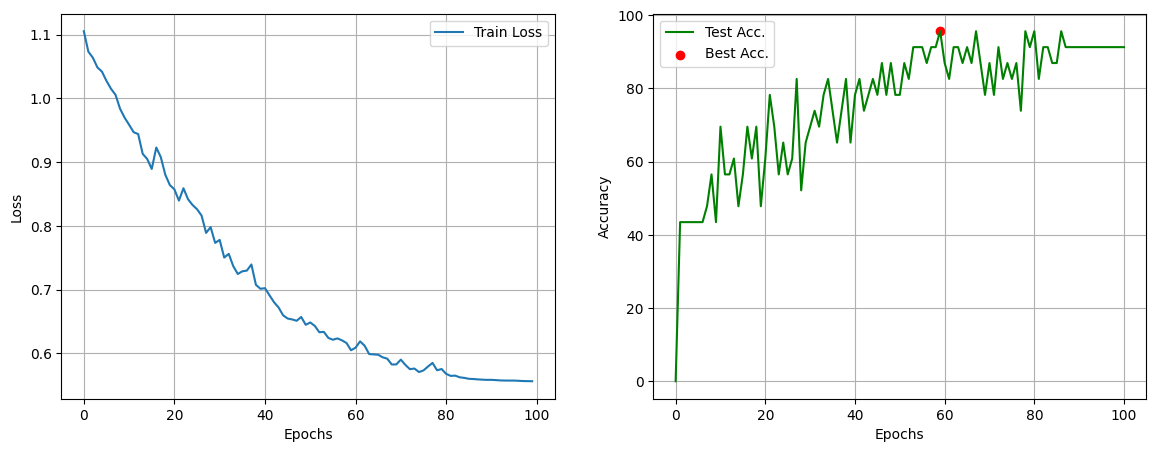

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(range(len(epoch_loss)), epoch_loss, label="Train Loss")
ax[1].plot(range(len(epoch_acc)), np.array(epoch_acc)*100.0, label="Test Acc.", color='green')
ax[1].scatter(best_epoch+1, epoch_acc[best_epoch+1]*100.0, color='r', label="Best Acc.")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
print()

- From the Testing Cell, we can get the avg. runtime of the model:
    - Total Test Examples: 22
    - Time Taken: 0.1 sec
    - Model Runtime Per Example: 4.545 msec

- Model Size:
    - This will give you the total number of parameters in the model, which indicates the size of the model in terms of memory consumption and computational complexity. 
    - Note that this count includes both trainable parameters (weights and biases) as well as any non-trainable parameters present in the model.

In [25]:
# Model Size

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

14060611


# Python Versions

In [ ]:
#!pip freeze